# TFG Alberto Pampín

En esta hoja se hará un análisis de los datos
provenientes de las mediciones de los sensores proporcionadas por el
ayuntamiento de la ciudad de Santiago de Compostela.

## Descripción del dataset

En primer lugar hay que hacer los imports necesarios:

In [82]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from math import ceil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [83]:
#csv_path = "../data/2_Oct2019.csv"
csv_path = "../data/historico_10_19_02_20.csv"
df = pd.read_csv(csv_path)


En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [84]:
df.head()

,_id,speed,sensor,flow,FID,datetime
0,1,-9999,PM084,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
1,2,-9999,PM036,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
2,3,-9999,PM037,0,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
3,4,-9999,PM083,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
4,5,-9999,PM082,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00


Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [85]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [86]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_id,2904410.0,292897.638104,171773.694631,1.0,145221.0,290441.5,435662.0,638663.0
speed,2904410.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

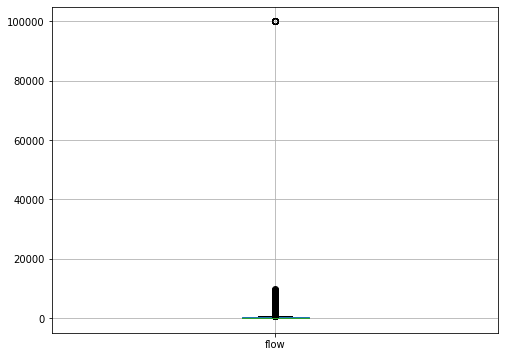

In [87]:
df.boxplot(column=['flow'])

In [88]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [89]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'].div(12)

In [90]:
df.head()

,sensor,flow,datetime,car_count
0,PM084,12,2019-10-01,1.0
1,PM036,12,2019-10-01,1.0
2,PM037,0,2019-10-01,0.0
3,PM083,12,2019-10-01,1.0
4,PM082,12,2019-10-01,1.0


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`

Seleccionemos 5 mediciones al azar:

In [91]:
df.sample(n=5, random_state=12)

,sensor,flow,datetime,car_count
1649509,PM034,0,2019-12-26 10:40:00,0.0
1399977,PM074,0,2019-12-13 23:50:00,0.0
367417,PM030,360,2019-10-19 17:45:00,30.0
413522,PM058,36,2019-10-21 22:20:00,3.0
983227,PM059,0,2019-11-27 04:45:00,0.0


Veamos algunas estadísticas del conjunto de datos:

In [92]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.00
car_count,2904410.0,12.338749,32.616900,0.0,0.0,4.0,19.0,8333.25


Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser tratados:

In [93]:
flow = df.loc[:, 'flow']
bad_max_flow = flow == flow.max()
df.loc[bad_max_flow, 'flow'] = 0.0

car_count = df.loc[:, 'car_count']
bad_max_car_count = car_count == car_count.max()
df.loc[bad_max_car_count, 'car_count'] = 0.0


TODO: HACER QUE EL VALOR SEA LA MEDIA ENTRE LOS 5 MIN ANTEIORES Y LOS 5 SIGUIENETS

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [94]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [95]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,146.997651,216.284387,0.0,0.0,48.0,228.0,9672.0
car_count,2904410.0,12.249804,18.023699,0.0,0.0,4.0,19.0,806.0


<AxesSubplot:>

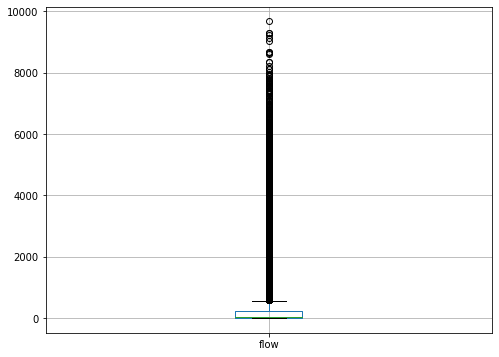

In [96]:
df.boxplot(column=['flow'])

Parece que ahora tiene algo más de sentido.

## Análisis sensores

Para el experimento no se tomarán en cuenta todos los sensores. Se seleccionará una zona que resulte de interés
para realizar la predicción del tráfico. Para ello se ha visualizado la ubicación de los sensores utilizando la herramienta
QGIS y se han seleccionado los siguientes sensores:

El punto a predecir (CITIUS) es el sensor`PM072`
1. Los sensores de entrada a la rotonda do Camiño Novo son: `PM030`, `PM031`, `PM032` y `PM033`
2. Los de salida son: `PM024` y `PM034`
3. Hacia Rosalía de Castro no hay sensor. Hay uno a la altura de Boel: `PM035`, pero perdemos el tráfico que va
hacia la Plaza de Vigo y cuenta los que vienen de la misma. En la Avenida de Villagarcía hay un sensor (`PM025`) que podría usarse para compensar la
pérdida del sensor de Boel, pero es peligroso, ya que cuenta también los coches que vienen de Rosalía de Castro
(en sentido rotonda), los de Santiago de Chile y perdemos los que van en sentido Plaza Roja.

Por otra parte, en la rotonda de la Galuresa tenemos:
1. De entrada: `PM076`, `PM077` y `PM079`
2. De salida: `PM016` (Perdemos los coches que entran en la estación de tren) y
`PM020` (Perdemos los coches que van por Santiago de Chile)

## Análisis dataset reducido

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [97]:
lista_sensores = ['PM016', 'PM020', 'PM024', 'PM030', 'PM031', 'PM032', 'PM033', 'PM034', 'PM072', 'PM076', 'PM077', 'PM079']

df = df.loc[df['sensor'].isin(lista_sensores)]

Al igual que antes, veamos algunos datos sobre este comjunto reducido:

In [21]:
df.sample(n=5)

,sensor,flow,datetime,car_count
619107,PM031,372,2019-10-31 19:10:00,31.000000
305463,PM076,266,2019-10-16 18:50:00,22.166667
2529861,PM020,24,2020-02-19 02:10:00,2.000000
769987,PM077,68,2019-11-16 23:40:00,5.666667
1666426,PM034,0,2019-12-27 06:00:00,0.000000


In [126]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,477098.0,196.893112,205.284441,0.0,12.0,144.0,324.0,8688.0
car_count,477098.0,16.407759,17.107037,0.0,1.0,12.0,27.0,724.0


Veamos un boxplot:

<AxesSubplot:>

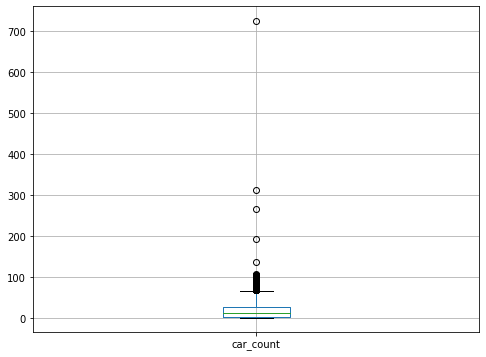

In [127]:
df.boxplot(column=['car_count'])

Observando el boxplot, parece bastante claro que las mediciones con un `car_count` **superior a 200** son erróneas. Resulta
casi imposible que en una ciudad como Santiago puedan pasar 50 coches en un solo minuto.

Veamos las mediciones con el máximo `car_count`:

In [128]:
df.loc[df['car_count'] > 150]

,sensor,flow,datetime,car_count
887859,PM079,2292,2019-11-22 14:20:00,191.000000
887861,PM077,3175,2019-11-22 14:20:00,264.583333
887862,PM076,3733,2019-11-22 14:20:00,311.083333
887895,PM016,8688,2019-11-22 14:20:00,724.000000


**Son todas el mismo día y a la misma hora, bastante interesante!**

Más adelante veremos si se trata de un error o no!

### Análisis gráfico
Veamos la evolución del tráfico a lo largo de estos meses en un sensor relevante.
El sensor escogido es el `PM072`, el que monitoriza el tráfico que entra en la rotonda
del CITIUS:


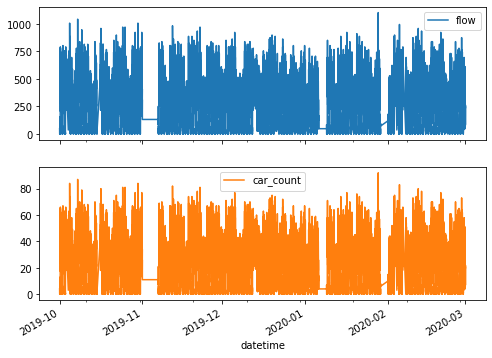

In [129]:
# Filas del sensor PM072
PM072_data = df.loc[df['sensor'] == 'PM072']

#Timestamps de los mediciones
date_time = PM072_data['datetime']

plot_cols = ['flow', 'car_count']
plot_features = PM072_data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

Las gráficas anteriores no son muy esclarecedoras, por lo que se ha creado una función de graficado.
La siguiente función recibe el nombre de un sensor, una lista de días y el dataset. Grafica
la información recopilada por ese sensor durante esos días.

In [130]:
def plot_sensors_daily_data(sensor, daylist, df_orig):

    df = df_orig.loc[df_orig['sensor'] == sensor]

    fig, axs = plt.subplots(daylist.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(daylist.shape[0]):
        x = df.loc[(df['datetime'] >= daylist[i]) & (df['datetime'] <= daylist[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= daylist[i]) & (df['datetime'] <= daylist[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ daylist[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

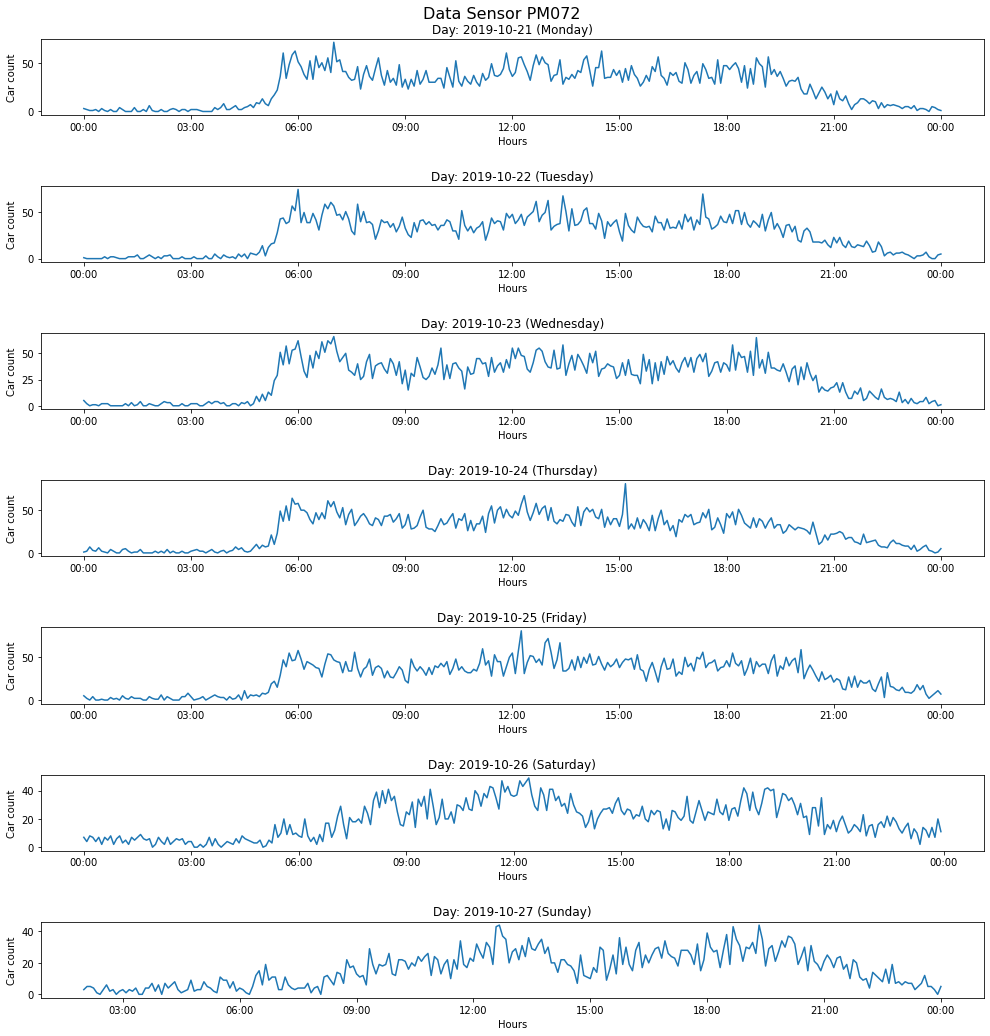

In [102]:
days = pd.date_range(start='2019-10-21', end='2019-10-27', freq='D')
plot_sensors_daily_data(sensor='PM072', daylist = days, df_orig=df)

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

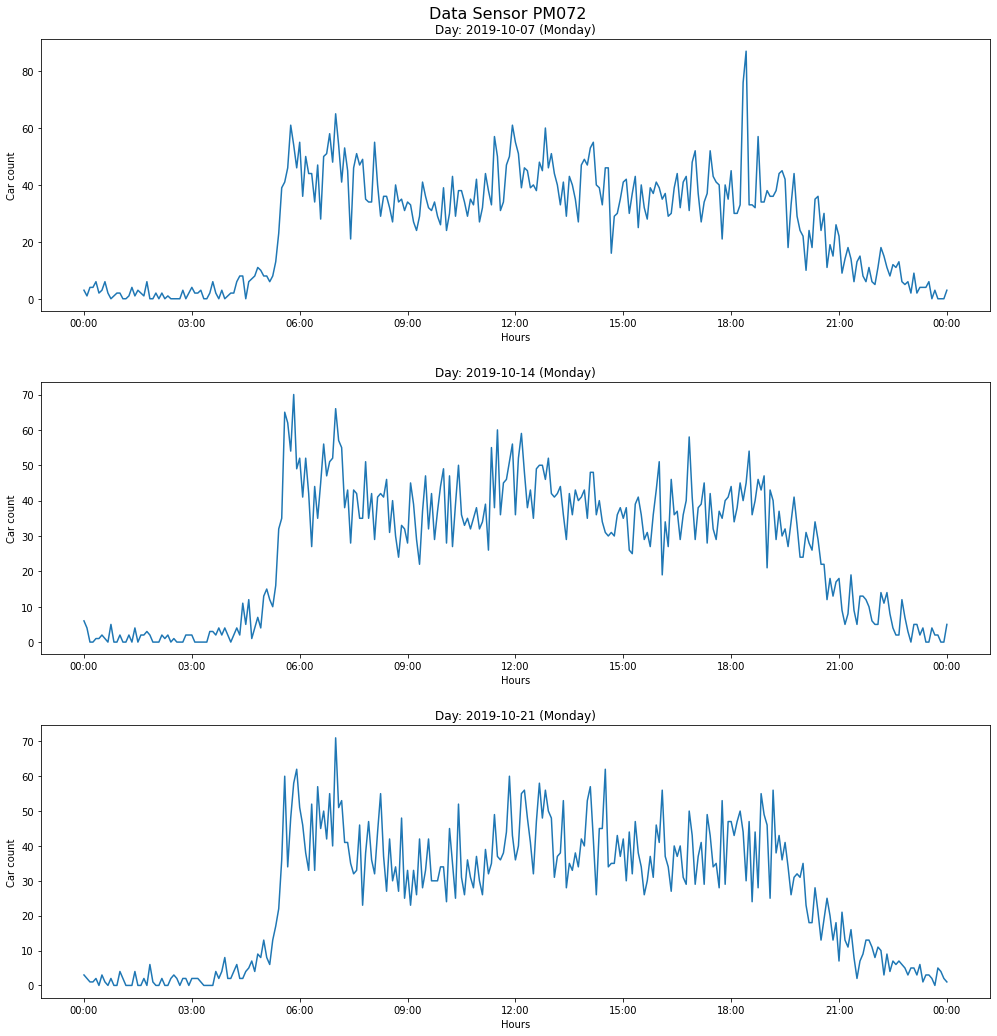

In [104]:
days = pd.date_range(start='2019-10-01', end='2019-10-21', freq='W-MON')
plot_sensors_daily_data(sensor='PM072', daylist = days, df_orig=df)

### Análisis gráfico outlayers

Veamos la evolución de las mediciones del sensor `PM016` durante la semana donde se alcanza el máximo `car_count`:

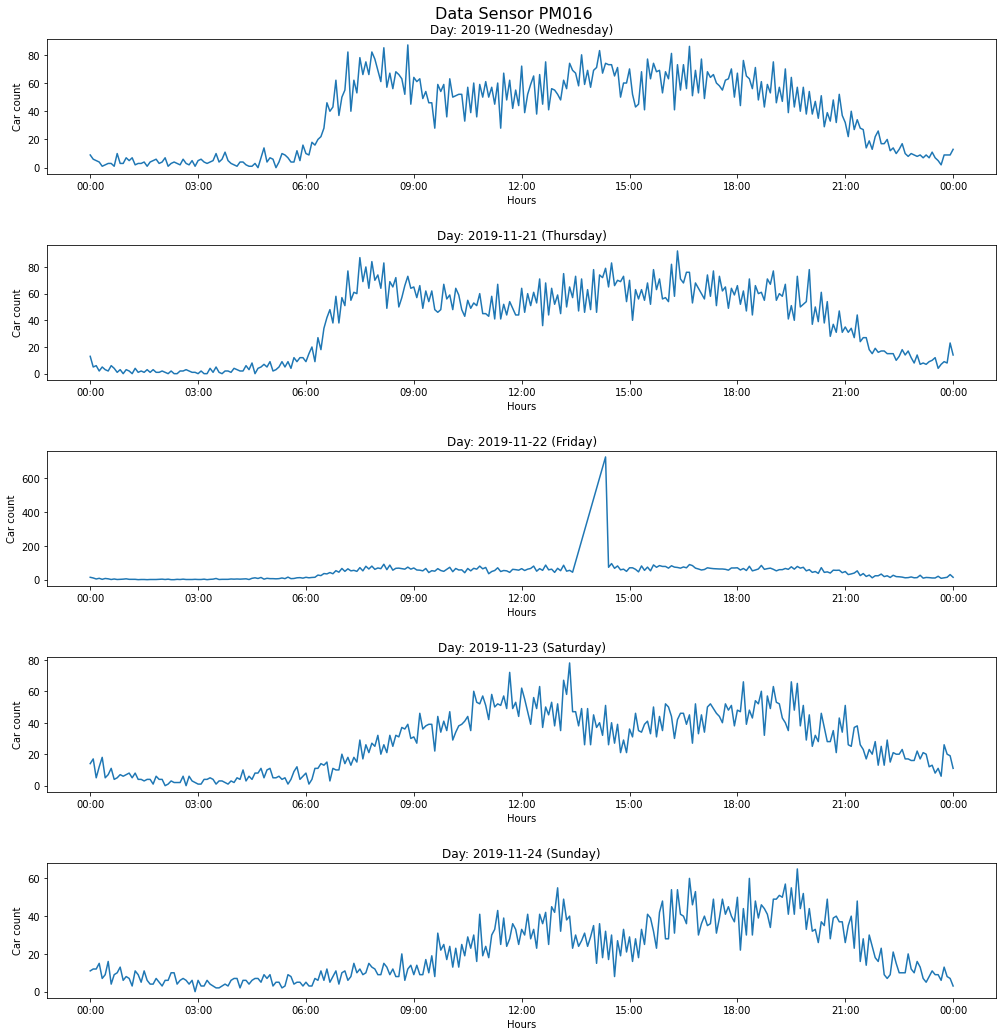

In [132]:
days = pd.date_range(start='2019-11-20', end='2019-11-24', freq='D')
plot_sensors_daily_data(sensor='PM016', daylist = days, df_orig=df)

Parece bastante claro que este valor se debe a un error. Veamos como se comportan los viernes de ese mes:

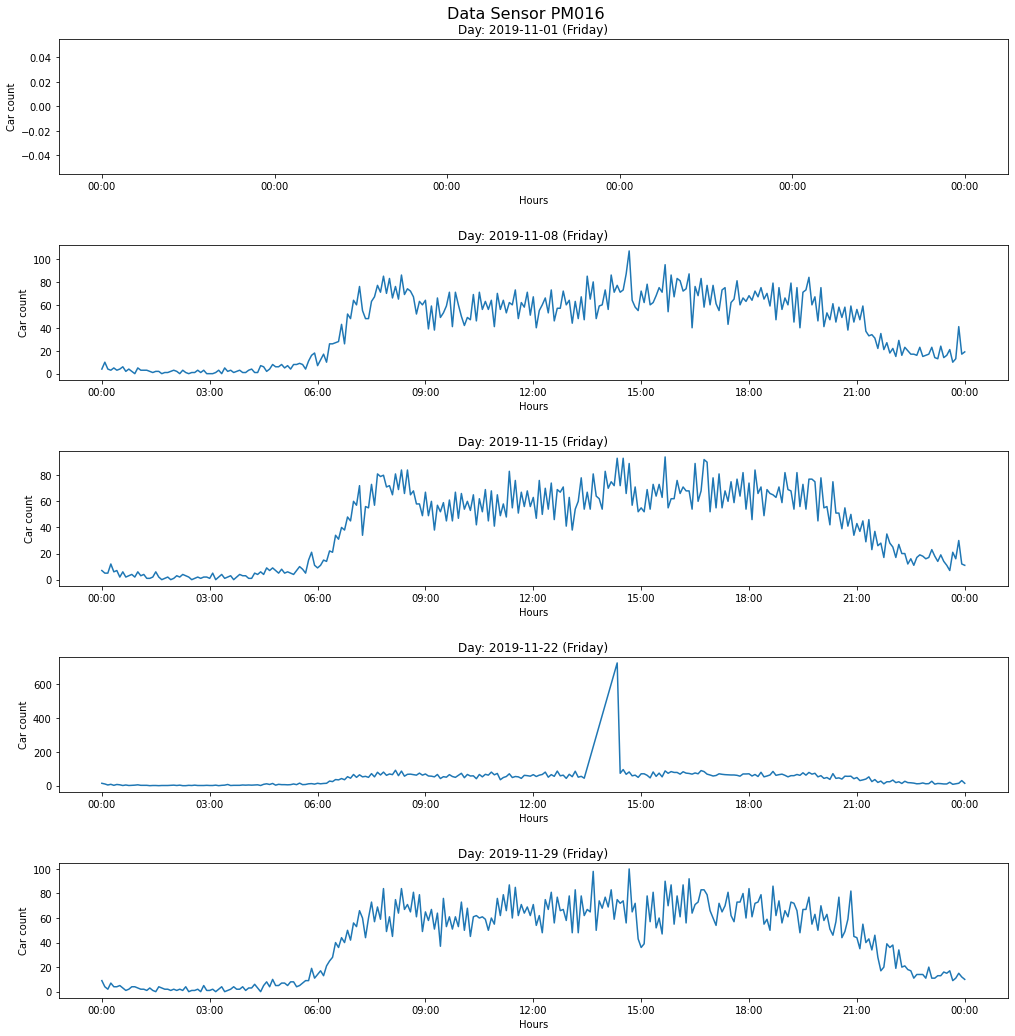

In [119]:
days = pd.date_range(start='2019-11-01', end='2019-11-30', freq='W-FRI')
plot_sensors_daily_data(sensor='PM016', daylist = days, df_orig=df)

**Definitivamente se trata de un outlayer!**

## Tratamiento de outlayers

In [ ]:
adf

fad
flowad
fa
df

adf
adf

af

## Feature engineering
Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

La columna `datetime` resulta de gran importancia, pero no como una cadena. El primer paso es pasarla
a segundos:

In [133]:
date_time = df.loc[:, 'datetime']
timestamp_s = date_time.map(datetime.datetime.timestamp)

5          1.569881e+09
9          1.569881e+09
10         1.569881e+09
11         1.569881e+09
12         1.569881e+09
               ...     
2904397    1.580512e+09
2904398    1.580512e+09
2904399    1.580512e+09
2904400    1.580512e+09
2904404    1.580512e+09
Name: datetime, Length: 477098, dtype: float64

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

**Más adelante tengo que discutir si es semanal, ya que si no cojo el finde...**

Para convertir el tiempo en una señal usable, se puede usar el seno y el coseno:

In [142]:
seconds_in_day = 24*60*60
df['sin_time'] = np.sin(timestamp_s * (2 * np.pi / seconds_in_day))
df['cos_time'] = np.cos(timestamp_s * (2 * np.pi / seconds_in_day))

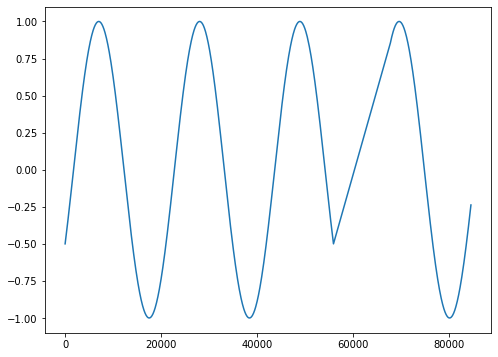

In [154]:
df.loc[df['sensor'] == 'PM072', 'sin_time'][:1000].plot();

Text(0.5, 1.0, 'Time of day signal')

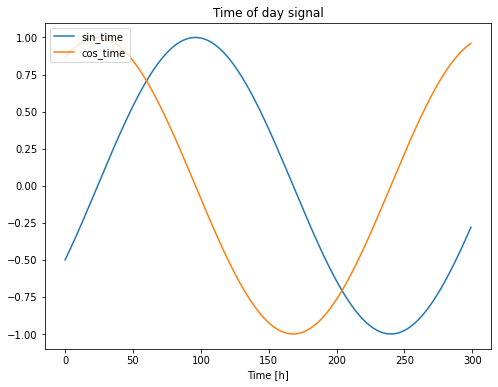

In [159]:
plt.plot(np.array(df.loc[df['sensor'] == 'PM072', 'sin_time'][:300]), label = 'sin_time')
plt.plot(np.array(df.loc[df['sensor'] == 'PM072', 'cos_time'][:300]), label = 'cos_time')
plt.legend(loc="upper left")
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [162]:
df.loc[df['sensor'] == 'PM072']


,sensor,flow,datetime,car_count,sin_time,cos_time
21,PM072,48,2019-10-01 00:00:00,4.0,-0.500000,0.866025
94,PM072,0,2019-10-01 00:05:00,0.0,-0.480989,0.876727
167,PM072,0,2019-10-01 00:10:00,0.0,-0.461749,0.887011
240,PM072,0,2019-10-01 00:15:00,0.0,-0.442289,0.896873
313,PM072,0,2019-10-01 00:20:00,0.0,-0.422618,0.906308
...,...,...,...,...,...,...
2904096,PM072,96,2020-02-01 00:20:00,8.0,-0.173648,0.984808
2904169,PM072,180,2020-02-01 00:15:00,15.0,-0.195090,0.980785
2904242,PM072,120,2020-02-01 00:10:00,10.0,-0.216440,0.976296
2904315,PM072,156,2020-02-01 00:05:00,13.0,-0.237686,0.971342


In [164]:
df.loc[df['sensor'] == 'PM072'][280:300]

,sensor,flow,datetime,car_count,sin_time,cos_time
20461,PM072,36,2019-10-01 23:20:00,3.0,-0.642788,0.766044
20534,PM072,0,2019-10-01 23:25:00,0.0,-0.625923,0.779884
20607,PM072,36,2019-10-01 23:30:00,3.0,-0.608761,0.793353
20680,PM072,0,2019-10-01 23:35:00,0.0,-0.591310,0.806445
20753,PM072,60,2019-10-01 23:40:00,5.0,-0.573576,0.819152
20826,PM072,24,2019-10-01 23:45:00,2.0,-0.555570,0.831470
20899,PM072,24,2019-10-01 23:50:00,2.0,-0.537300,0.843391
20972,PM072,36,2019-10-01 23:55:00,3.0,-0.518773,0.854912
21045,PM072,24,2019-10-02 00:00:00,2.0,-0.500000,0.866025
21118,PM072,24,2019-10-02 00:05:00,2.0,-0.480989,0.876727


## Normalización de los datos